# Makemore Park 2: Integrating a MLP
Based off of Bengio et al. 2003 (MLP langauge model) paper but using character prediction instead of word prediction

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [5]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# compile the dataset for the neural network

# for every 3 preceding characters we are looking for a specific output character
# this compiles the dataset into that format

# build the dataset
block_size = 3 # context lenth: how many characters do we take to predict the next one? -- chosen from the paper
X, Y = [], []
for w in words:
    
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [8]:
X.shape # inputs

torch.Size([228146, 3])

In [9]:
Y.shape # labels (expected values)

torch.Size([228146])

In [10]:
# build the neural network

C = torch.randn((27, 2)) # 2 dimensional lookup table -- 27 rows and 2 colums -- each character will have a 2D embedding

In [11]:
# example of embedding one integer
C[5] # one way to do it by indexing

# from the previous lecture...
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.0907, -0.7185])

Both of the above ways will result in the same tensor, but we'll be using indexing simply because it is faster than one_hot

In [12]:
emb = C[X] # embeding X into C
emb.shape

torch.Size([228146, 3, 2])

In [13]:
# hidden layer
W1 = torch.randn((6, 100)) # 100 nuerons chosen randomly
b1 = torch.randn(100)

Currently we have two matrices we need to multiply but they are not compatiable sizes. We have a 32,3,2 and a 6,100. We need to convert the first one to a 32,6 so that they can be multiplied. We will solve this by using torch's cat function (concatanate)

In [14]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)

tensor([[ 0.0989,  0.3944,  0.0989,  0.3944,  0.0989,  0.3944],
        [ 0.0989,  0.3944,  0.0989,  0.3944,  0.0907, -0.7185],
        [ 0.0989,  0.3944,  0.0907, -0.7185,  0.6883, -1.9755],
        ...,
        [-0.4107, -0.7114, -0.4107, -0.7114,  0.0588, -0.3474],
        [-0.4107, -0.7114,  0.0588, -0.3474, -0.4107, -0.7114],
        [ 0.0588, -0.3474, -0.4107, -0.7114,  1.4880, -0.0618]])

The problems with this is that we are indexing directly and so if we ever wanted to change the number of context words, we would have to change this code as well (not ideal). So, we can use torch's unbind function to remove a dimension 

In [15]:
torch.cat(torch.unbind(emb, 1), 1)

tensor([[ 0.0989,  0.3944,  0.0989,  0.3944,  0.0989,  0.3944],
        [ 0.0989,  0.3944,  0.0989,  0.3944,  0.0907, -0.7185],
        [ 0.0989,  0.3944,  0.0907, -0.7185,  0.6883, -1.9755],
        ...,
        [-0.4107, -0.7114, -0.4107, -0.7114,  0.0588, -0.3474],
        [-0.4107, -0.7114,  0.0588, -0.3474, -0.4107, -0.7114],
        [ 0.0588, -0.3474, -0.4107, -0.7114,  1.4880, -0.0618]])

This will work, however there is actaully an even better more efficent way to do this. We can use torch.view() to alter the dimensions of the matrix. As long as they multiply to the same value, we can shape the matrix any way we want to. This doesn't acutally alter the storage of emb, instead it just changes how that data is viewed internally.

In [17]:
emb.view(32, 6)

RuntimeError: shape '[32, 6]' is invalid for input of size 1368876

Now we can simply use view to alter the matrix and allow it to be multiplied by the weights.

In [18]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # using -1 lets pytorch infer what the value should be (based on the og size)
h


tensor([[-0.3417,  0.2383,  0.9875,  ...,  0.7990, -0.0490, -0.0542],
        [-0.1474,  0.5239,  0.7186,  ...,  0.5782, -0.0049,  0.0055],
        [ 0.8889,  0.6177, -0.8485,  ...,  0.3921, -0.7278,  0.7654],
        ...,
        [-0.4684,  0.2252, -0.8067,  ..., -0.6629,  0.1099,  0.4471],
        [-0.2161, -0.2360, -0.9748,  ..., -0.8464, -0.6152,  0.4613],
        [-0.7951,  0.9890,  0.5224,  ...,  0.9468,  0.6295,  0.6839]])

In [19]:
# final layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [20]:
logits = h @ W2 + b2

In [21]:
counts = logits.exp() # get fake counts

In [22]:
prob = counts / counts.sum(1, keepdim=True) # normalize into a probability

In [23]:
# comparing to label (expected character)
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

## Putting this together
Now, we're going to take everything we made above and make it look more organized

In [87]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [93]:
# building parameters using a generator
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [94]:
# counting number of parameters
sum(p.nelement() for p in parameters) # number of parameters in total

3481

We need to require gradients for every parameter in the neural network. By default it is off becuase Tensor takes care of gradient when using their neural network. Since we are buidling our own neural network, we need to turn this on to get the gradient for each parameter.

In [95]:
for p in parameters:
    p.requires_grad = True

In [65]:
for _ in range(100):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # creating a minibatch of size 32
    
    # calculating loss (forward pass)
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()

    # we can replace the above lines with a more condensed and efficient version
    # it doesnt create new tensors like we do above but uses fused kernels for efficiency
    # this also makes the backward pass more efficient bc the formulas can be simplified
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data += -1 * p.grad # manual value is learning rate
# print(loss.item())  

21.556304931640625
15.856295585632324
12.287732124328613
11.347538948059082
15.4568510055542
11.158556938171387
12.20604133605957
13.361774444580078
10.342698097229004
9.303770065307617
10.26659870147705
15.275646209716797
8.97019100189209
11.23560905456543
8.488992691040039
10.541656494140625
8.632801055908203
7.550400733947754
9.809893608093262
12.434541702270508
13.016610145568848
11.697427749633789
9.402116775512695
11.1528902053833
13.054740905761719
8.816349029541016
12.807260513305664
12.04638385772705
11.644514083862305
11.631548881530762
8.438801765441895
8.171278953552246
8.938568115234375
13.060914993286133
13.514371871948242
10.73193645477295
10.064732551574707
8.674356460571289
9.12108039855957
6.694490432739258
8.400970458984375
8.771952629089355
10.345026969909668
9.66441535949707
5.981971740722656
9.76171875
10.438935279846191
8.985917091369629
8.054986000061035
9.683183670043945
9.729411125183105
7.934333324432373
9.02791690826416
8.011935234069824
8.677255630493164
9.

In [53]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5732, grad_fn=<NllLossBackward0>)

Another problem with our original approach is that with very large values in our logits (which may happen during optimization), we run out of room in our float and we get 'inf' which becomes 'nan' when calcualting probs -- very very bad :(. Pytorch solved this by realizing that you could offset logits by any value and get the same probs result. Since negative values are ok but positive is bad, pytorch subtracts the largets value in the tensor from the logits. This makes the largest value in logits 0 and every other value will be negative. Yay no more problems (well behaved).

## Optimizing training
In reality, we don't train over the entire dataset every single time. Instead, we will do forward, backward and update passes over mini batches of the dataset

In [55]:
torch.randint(0, X.shape[0], (32,)) # creating a minibatch of size 32

tensor([139882, 119120, 223494,  29271,   3568, 164331,  79949,  68703, 112697,
        113944,  27925, 198053,  57313,  19868, 181198,  97608,  43143, 216098,
         82156, 121624,  75398,  89778,  34704, 117608, 150266, 124115, 165396,
         51251, 126151,  50540,  14701,   5227])

## Learning Rate
How do we determine the learning rate? 

__STOPPED AT 45:52!!!!!!!!!__

We found (through manual testing) that the optimal learning rate is somewhere between 0.001 and 1. To test different learning spaces were going to use linspace. This will result in the possible learning rates which we can search over.

In [67]:
torch.linspace(0.001, 1, 1000) # creates a tensor of 1000 values between 0.001 and 1

tensor([0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090,
        0.0100, 0.0110, 0.0120, 0.0130, 0.0140, 0.0150, 0.0160, 0.0170, 0.0180,
        0.0190, 0.0200, 0.0210, 0.0220, 0.0230, 0.0240, 0.0250, 0.0260, 0.0270,
        0.0280, 0.0290, 0.0300, 0.0310, 0.0320, 0.0330, 0.0340, 0.0350, 0.0360,
        0.0370, 0.0380, 0.0390, 0.0400, 0.0410, 0.0420, 0.0430, 0.0440, 0.0450,
        0.0460, 0.0470, 0.0480, 0.0490, 0.0500, 0.0510, 0.0520, 0.0530, 0.0540,
        0.0550, 0.0560, 0.0570, 0.0580, 0.0590, 0.0600, 0.0610, 0.0620, 0.0630,
        0.0640, 0.0650, 0.0660, 0.0670, 0.0680, 0.0690, 0.0700, 0.0710, 0.0720,
        0.0730, 0.0740, 0.0750, 0.0760, 0.0770, 0.0780, 0.0790, 0.0800, 0.0810,
        0.0820, 0.0830, 0.0840, 0.0850, 0.0860, 0.0870, 0.0880, 0.0890, 0.0900,
        0.0910, 0.0920, 0.0930, 0.0940, 0.0950, 0.0960, 0.0970, 0.0980, 0.0990,
        0.1000, 0.1010, 0.1020, 0.1030, 0.1040, 0.1050, 0.1060, 0.1070, 0.1080,
        0.1090, 0.1100, 0.1110, 0.1120, 

This won't work well because we won't be spaced between each value, so instead we will use an exponential version.

In [71]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

Now, we will include these learning rates in the training. This will mean that the learning rate will start as 0.001 and end at 1. Along the way we will track stats for each learning rate and its associated loss.

In [96]:
# for tracking learning rate stats
lri = []
lossi = []

for i in range(1000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # creating a minibatch of size 32
    
    # calculating loss (forward pass)
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()

    # we can replace the above lines with a more condensed and efficient version
    # it doesnt create new tensors like we do above but uses fused kernels for efficiency
    # this also makes the backward pass more efficient bc the formulas can be simplified
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad # manual value is learning rate
        
    # track stats for learning rate
    lri.append(lre[i])
    lossi.append(loss.item())
# print(loss.item())  

19.483184814453125
22.354785919189453
20.80984115600586
17.23212242126465
17.62961196899414
18.437232971191406
21.97251319885254
20.00156021118164
23.7876033782959
16.508405685424805
20.313186645507812
19.712778091430664
17.695693969726562
17.681489944458008
20.660940170288086
17.446788787841797
20.983671188354492
18.088838577270508
17.385412216186523
18.134172439575195
19.71392250061035
20.150527954101562
17.924795150756836
15.3855562210083
18.966066360473633
16.288278579711914
17.840993881225586
18.433530807495117
17.428409576416016
20.908248901367188
16.58711051940918
21.205387115478516
19.61207389831543
21.774906158447266
14.176729202270508
19.85826873779297
17.191495895385742
15.66231918334961
19.170988082885742
16.50863265991211
16.77484893798828
17.530668258666992
19.951326370239258
17.47499656677246
15.604483604431152
16.264934539794922
19.246116638183594
14.682537078857422
20.819894790649414
16.603818893432617
18.29820442199707
18.85133171081543
16.762313842773438
18.601854324

Using the collected data, we can plot a graph between learning rate and loss to see where the best learning rate is.

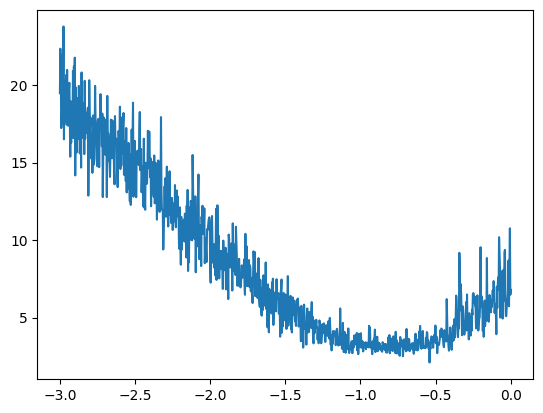

In [97]:
plt.plot(lri, lossi)

This graph shows that -1.0 (which would result in a learning rate of 0.1 -- 10**-1 = 0.1) is a really good learning rate. It graph seems to flatten out a bit there before blowing up again. So, our orignal learning rate was a good choice but now we have confidence (and proof) of that. We can remove the learning rate code and just manually put in 0.1 and run the model for much longer.

Note: learning rate decay is where you change your learning rate (decrease by a factor) in the late stages of training to further refine the model. In this case, we will change the learning rate to 0.01 (reduced by a factor of 10).

In [111]:
# for tracking learning rate stats
# lri = []
# lossi = []

for i in range(10000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # creating a minibatch of size 32
    
    # calculating loss (forward pass)
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()

    # we can replace the above lines with a more condensed and efficient version
    # it doesnt create new tensors like we do above but uses fused kernels for efficiency
    # this also makes the backward pass more efficient bc the formulas can be simplified
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad # manual value is learning rate
        
    # track stats for learning rate
    # lri.append(lre[i])
    # lossi.append(loss.item())
print(loss.item())  

2.0147757530212402


This model is performing better than the previous bigram model (which acheived a loss of about 2.5 compared to the almost 2.0 loss here).

## Is the Model Really Better?
As the model gets bigger and bigger, the chance of overfitting on the training set.

Overfiting: the loss will get very low (maybe even 0) but all the model is doing is simply memorizing the training data. If you try and sample from this model, you will only get examples exactly from the training set. Additionally, if you try and evalute loss on a different set (of novel data) the loss may be very high.

### 3 Splits
This means you need to split the training data into 3 different sections.

1. Training split -- 80% -- used to optimize parameters using gradient descent
2. Validation/dev split -- 10% -- development over all the hyperparameters (size of embiddings, hidden layers etc.)
3. Test split -- 10% -- evaluate performance after training (use sparingly to avoid training on the test split)

We're now going to break up our data into these three splits.

In [6]:
# build the dataset

# builds a dataset only on the words passed in
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# randomly shuffling the words
import random
random.seed(42)
random.shuffle(words)

# 80% of the words
n1 = int(0.8*len(words))

# 90% of the words
n2 = int(0.9*len(words))

# build training set
Xtr, Ytr = build_dataset(words[:n1])

# build dev set
Xdev, Ydev = build_dataset(words[n1:n2])

# build test set
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


Now we will incorporate these sets into the model.

In [ ]:
# training set
Xtr.shape, Ytr.shape # dataset

In [ ]:
# initializing neural network using a generator
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
# for tracking learning rate stats
lri = []
lossi = []

for i in range(1000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # creating a minibatch of size 32
    
    # calculating loss (forward pass)
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()

    # we can replace the above lines with a more condensed and efficient version
    # it doesnt create new tensors like we do above but uses fused kernels for efficiency
    # this also makes the backward pass more efficient bc the formulas can be simplified
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad # manual value is learning rate
        
    # track stats for learning rate
    lri.append(lre[i])
    lossi.append(loss.item())
# print(loss.item())  